# Background

The final project of GEOG 4463-5463 (Earth Analytics Bootcamp) is to look into building a habitat suitability model for Sorghasstrum Nutans.\
In the past 50 years, its range has been moving northward according to Global Biodiversity Information Facility at https://www.gbif.org/species/2704414.

In this notebook, I am demonstrating the ability to analyze three study sites by utilizing modular, reproducible for loops and functions, so you may add as different/additional study sites into this notebook as needed.

---------

A quick search online suggests Sorghasstrum Nutans, also known as "Tomahawk" Indiangrass, favors these conditions:
* moderate elevations and open woodlands,
* average annual precipitation ranged from 15 to 50 inches (average monthly ~32mm to ~64 mm)
* neutral soil pH (slightly acidic would be okay but will not adapted well to highly saline or alkaline conditions)
* moist, well drained soil

Tober, D. A. (2009). Indiangrass (Sorghastrum Nutans): Biomass Trials North Dakota, South Dakota, and Minnesota. Agriculture Department, Natural Resources Conservation Service. https://www.govinfo.gov/app/details/GOVPUB-A57-PURL-gpo1710

---------

# Data Preparation

I loosely selected three study sites near me: Oglala National Grassland (Nebraska), Pawnee National Grassland (Colorado), and Fort Pierre National Grassland (South Dakota).

In [1]:
import math
import os
from glob import glob
from itertools import combinations
from urllib.error import URLError

import earthpy as et
import earthpy.appeears as etapp
import geopandas as gpd
import holoviews as hv
import hvplot as hv
import hvplot.pandas
import hvplot.xarray
import numpy as np
import pandas as pd
import requests
import rioxarray as rxr
import rioxarray.merge as rxrmerge
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from IPython.display import Image
import utm
import xarray as xr
import xrspatial
import warnings

warnings.filterwarnings('ignore')

data_dir = os.path.join(et.io.HOME, et.io.DATA_NAME, 'sorghastrum-nutans')
bounadaries_dir = os.path.join(data_dir, 'boundaries')
polaris_dir = os.path.join(data_dir, 'polaris')
precipitation_dir = os.path.join(data_dir, 'precipitation')
humidity_dir = os.path.join(data_dir, 'humidity')

for dir in [data_dir, bounadaries_dir, polaris_dir, precipitation_dir, humidity_dir]:
    """
    Create directories if they don't exist
    """
    if not os.path.exists(dir):
        os.makedirs(dir)

In [2]:
def get_utm_epsg(lat, lon):
    """
    Get the UTM EPSG code based on latitude and longitude.

    Parameters:
    lat: Latitude in decimal degrees.
    lon: Longitude in decimal degrees.

    Returns:
    str: UTM EPSG code.
    """
    easting, northing, zone_number, zone_letter = utm.from_latlon(lat, lon)
    return f"326{zone_number}"

In [3]:
def get_center_lon_lat(gdf):
    """
    Get the longitude and latitude of the centroid of a GeoDataFrame.

    Parameters:
    gdf (GeoDataFrame): The input GeoDataFrame.

    Returns:
    lon: The longitude of the centroid.
    lat: The latitude of the centroid.
    """
    lon, lat = gdf.centroid.iloc[0].coords[0]
    return lon, lat

## Data Source #1: Forest Service National Grassland Boundaries

Before downloading my raster data, I need to begin with getting my shape files, which is collected and maintained by Forest Service programs at https://data.fs.usda.gov/geodata/edw/datasets.php

### Data Citation
United States Forest Service (USFS). (2023). U.S. National Grassland Shapefiles [Data set]. USFS Enterprise Data Warehouse. Accessed 2023-12-18 from https://data.fs.usda.gov/geodata/edw/edw_resources/shp/S_USA.NationalGrassland.zip

In [4]:
usfs_grassland_url = (
    'https://data.fs.usda.gov/geodata/edw'
    '/edw_resources/shp/S_USA.NationalGrassland.zip'
)

try:
    grass_shapefile = os.path.join(
        bounadaries_dir, 'grasslands.shp')
    if not os.listdir(bounadaries_dir):
        gdf = gpd.read_file(usfs_grassland_url)
        gdf.to_file(grass_shapefile)
    else:
        gdf = gpd.read_file(grass_shapefile)
except URLError as e:
    print(f"Failed to open URL: {e.reason}")


In [5]:
targets_gdf = (gdf.set_index('GRASSLANDN')
               .loc[[
                     'Oglala National Grassland', 
                     'Pawnee National Grassland',
                     'Fort Pierre National Grassland',
                     # 'Little Missouri National Grassland',
                     # 'Buffalo Gap National Grassland'
                  ]])
targets_gdf

NATIONALGR   GIS_ACRES  SHAPE_AREA  \
GRASSLANDN                                                             
Oglala National Grassland       295521010328  215804.927    0.096279   
Pawnee National Grassland       295523010328  208424.885    0.089972   
Fort Pierre National Grassland  281771010328  209044.225    0.095149   

                                SHAPE_LEN  \
GRASSLANDN                                  
Oglala National Grassland        1.970612   
Pawnee National Grassland       15.341594   
Fort Pierre National Grassland   1.455518   

                                                                         geometry  
GRASSLANDN                                                                         
Oglala National Grassland       POLYGON ((-103.72477 43.00100, -103.72007 43.0...  
Pawnee National Grassland       MULTIPOLYGON (((-104.58106 40.82664, -104.5810...  
Fort Pierre National Grassland  POLYGON ((-100.08409 44.28162, -100.08409 44.2...

In [6]:
grasslands = []
for index, row in targets_gdf.iterrows():
    """
    Create a dictionary for each grassland to track all the information.
    """
    temp_gdf = targets_gdf.loc[[index]]
    lon, lat = get_center_lon_lat(temp_gdf)
    utm_epsg = int(get_utm_epsg(lat, lon))
    temp_dict = {
        "name": index,
        "original_gdf": temp_gdf,
        "reprojected_gdf": temp_gdf.to_crs(utm_epsg),
        "download_key": f'srtm-{index.split(" ")[0].lower()}',
        "utm_epsg": utm_epsg
    }
    grasslands.append(temp_dict)
    temp_gdf.to_file(os.path.join(bounadaries_dir, f'{index}.shp'))

In [7]:
def check_gl_keys(grasslands):
    """
    Prints the keys and their corresponding values for each grassland dictionary in the given list.

    Args:
        grasslands (list): A list of grassland dictionaries.

    Returns:
        None
    """
    for index, grassland in enumerate(grasslands):
        for key in grasslands[index].keys():
            if key != 'gdf':
                print(f"{key}:{grasslands[index][key]}")
        print('')

## Data Source #2: SRTM Elevation Data (2000)

Next, I downloaded my elevation data, NASA Shuttle Radar Topography Mission (SRTM) dataset, available from the APPEEARS API at https://appeears.earthdatacloud.nasa.gov/

Fun Fact:
> NASA Shuttle Radar Topography Mission (SRTM) datasets result from a collaborative effort by the National Aeronautics and Space Administration (NASA) and the National Geospatial-Intelligence Agency (NGA - previously known as the National Imagery and Mapping Agency, or NIMA), as well as the participation of the German and Italian space agencies. The purpose of SRTM was to generate a near-global digital elevation model (DEM) of the Earth using radar interferometry. SRTM was a primary component of the payload on the Space Shuttle Endeavour during its STS-99 mission. Endeavour launched February 11, 2000 and ﬂew for 11 days.
(https://lpdaac.usgs.gov/products/srtmgl1v003/)

### Data Citation
NASA JPL (2013). <i>NASA Shuttle Radar Topography Mission Global 1 arc second</i> [Data set]. NASA EOSDIS Land Processes Distributed Active Archive Center. Accessed 2023-12-18 from https://doi.org/10.5067/MEaSUREs/SRTM/SRTMGL1.003


In [8]:
def download_elevation_data(gdf, download_key):
    """
    Downloads elevation data using the AppeearsDownloader class from the et-appeears package.

    Parameters:
    - gdf (geopandas.GeoDataFrame): GeoDataFrame representing the polygon of interest.
    - download_key (str): Key used for downloading the data.

    Returns:
    None
    """
    srtm_downloader = etapp.AppeearsDownloader(
        ea_dir=data_dir,
        download_key=download_key,
        product='SRTMGL1_NC.003',
        layer='SRTMGL1_DEM',
        start_date='02-11-2000',
        end_date='02-21-2000',
        polygon=gdf
    )
    temp_download_dir = os.path.join(data_dir, download_key)
    # print(f"Checking for {temp_download_dir}")
    if not os.path.exists(temp_download_dir):
        # print(f"Downloading data...{download_key}")
        srtm_downloader.download_files()
    else:
        # print(f"Data already downloaded...{download_key}")
        pass

for grassland in grasslands:
    """
    Download the elevation data for each grassland.
    """
    download_elevation_data(grassland['original_gdf'], grassland['download_key'])
    grassland['srtm_path'] = os.path.join(data_dir, grassland['download_key'])
    target_pattern = os.path.join(
        data_dir, 
        grassland['download_key'], 
        'SRTMGL1_NC.003*',
        '*.tif'
        )
    grassland['srtm_paths'] = glob(target_pattern)

In [9]:
def check_gl_keys(grasslands):
    """
    Prints the keys and their corresponding values for each grassland dictionary in the given list.

    Args:
        grasslands (list): A list of grassland dictionaries.

    Returns:
        None
    """
    for index, grassland in enumerate(grasslands):
        for key in grasslands[index].keys():
            if key != 'gdf':
                print(f"{key}:{grasslands[index][key]}")
        print('')

In this section, I am demonstrating the ability to calculate a derived topographic variable to use in the model:

```
for index, grassland in enumerate(grasslands):
    elevation_data = [rxr.open_rasterio(path, masked=True).squeeze() for path in grasslands[index]['srtm_paths']][0]
    grasslands[index]['elevation_data'] = elevation_data

for index, grassland in enumerate(grasslands):
    """
    Calculate the aspect of the elevation data for each grassland and create an elevation plot.
    """
    elevation_plot = xrspatial.aspect(grasslands[index]['elevation_data']).hvplot.image(
        rasterize=True, cmap='BrBG_r',
        xlabel='Longitude', ylabel='Latitude',
        colorbar=True,
        clim=(0, 400),
        x='x', y='y', crs=grasslands[index]['utm_epsg'])
    grasslands[index]['elevation_plot'] = elevation_plot
```

In [10]:
for index, grassland in enumerate(grasslands):
    """
    Open the elevation data for each grassland and merge them into a single xarray DataArray.
    """
    elevation_data = (
        rxrmerge.merge_arrays(
            [rxr.open_rasterio(path, masked=True).squeeze() 
             for path in grasslands[index]['srtm_paths']])
        )

    grasslands[index]['elevation_data'] = elevation_data

In [11]:
for index, grassland in enumerate(grasslands):
    """
    Calculate the aspect of the elevation data for each grassland and create an elevation plot.
    """
    elevation_aspect = xrspatial.aspect(grasslands[index]['elevation_data'])
    grasslands[index]['elevation_aspect'] = elevation_aspect
    elevation_plot = elevation_aspect.hvplot.image(
        rasterize=True, cmap='BrBG_r',
        xlabel='Longitude', ylabel='Latitude',
        colorbar=True,
        clabel='Azimuthal Direction (degrees)',
        clim=(0, 400),
        x='x', y='y', crs=grasslands[index]['utm_epsg'])
    grasslands[index]['elevation_plot'] = elevation_plot

### Elevation Maps

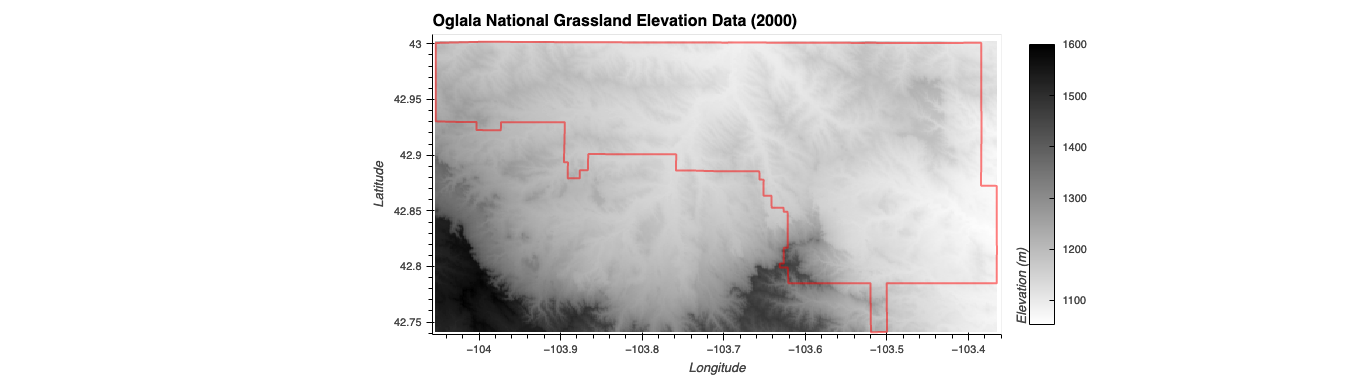

In [12]:
# plot = grasslands[0]['elevation_data'].hvplot.image(
#     rasterize=True, cmap='binary',
#     xlabel='Longitude', ylabel='Latitude',
#     colorbar=True,
#     clabel='Elevation (m)',
#     clim=(grasslands[0]['elevation_data'].values.min(), grasslands[0]['elevation_data'].values.max()),
#     x='x', y='y', crs=grasslands[0]['utm_epsg'])
# plot = (
#     plot * 
#     grasslands[0]['original_gdf']
#     .to_crs(grasslands[0]['utm_epsg'])
#     .hvplot(geo=True, alpha=0.5, 
#             line_color='red', line_width=2,
#             color='None', 
#             crs=grasslands[0]['utm_epsg'])
# ).opts(title=f'{grasslands[0]["name"]} Elevation Data (2000)')
# hv.save(plot, f"img/{grasslands[0]['name']} - Elevation.png")
Image('img/Oglala National Grassland - Elevation.png')

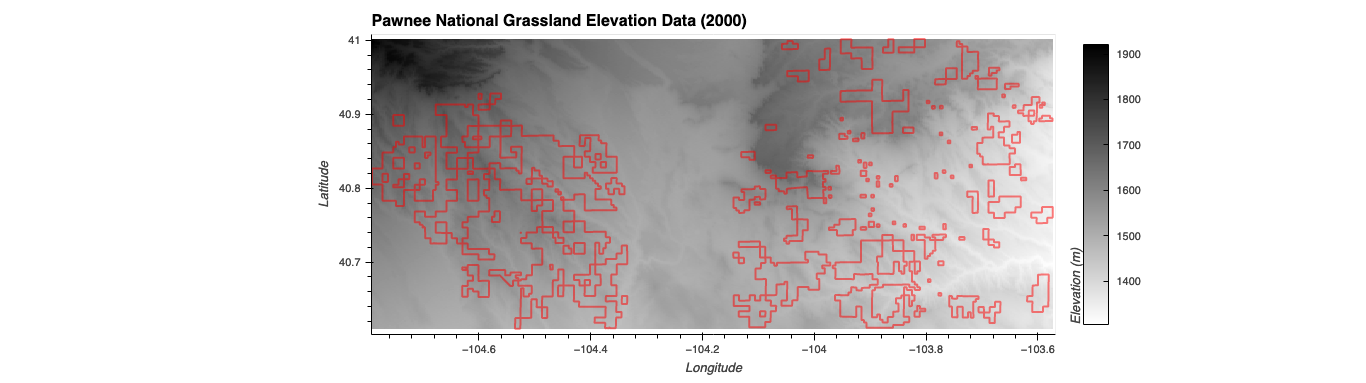

In [13]:
# plot = grasslands[1]['elevation_data'].hvplot.image(
#     rasterize=True, cmap='binary',
#     xlabel='Longitude', ylabel='Latitude',
#     colorbar=True,
#     clabel='Elevation (m)',
#     clim=(grasslands[1]['elevation_data'].values.min(), grasslands[1]['elevation_data'].values.max()),
#     x='x', y='y', crs=grasslands[1]['utm_epsg'])
# plot = (
#     plot * 
#     grasslands[1]['original_gdf']
#     .to_crs(grasslands[1]['utm_epsg'])
#     .hvplot(geo=True, alpha=0.5, 
#             line_color='red', line_width=2,
#             color='None', 
#             crs=grasslands[1]['utm_epsg'])
# ).opts(title=f'{grasslands[1]["name"]} Elevation Data (2000)')
# hv.save(plot, f"img/{grasslands[1]['name']} - Elevation.png")
Image('img/Pawnee National Grassland - Elevation.png')

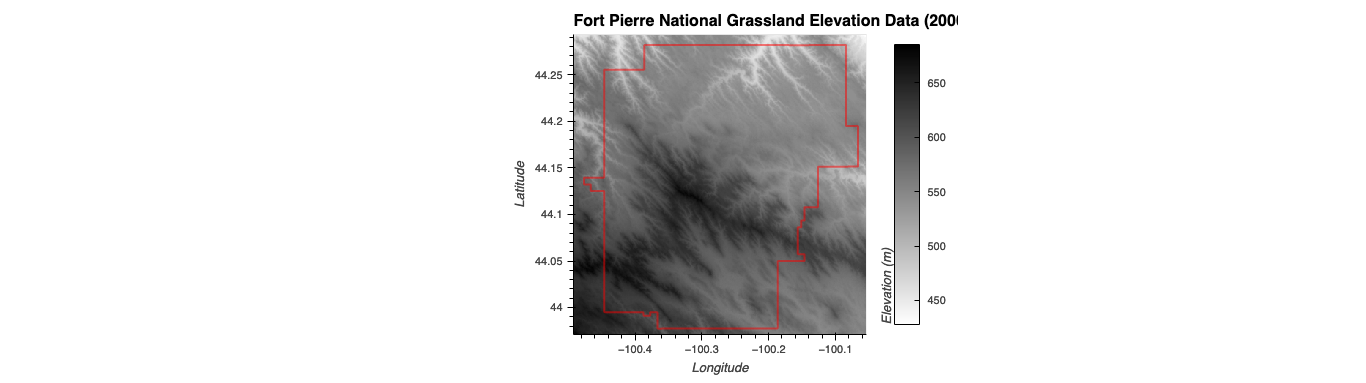

In [14]:
# plot = grasslands[2]['elevation_data'].hvplot.image(
#     rasterize=True, cmap='binary',
#     xlabel='Longitude', ylabel='Latitude',
#     colorbar=True,
#     clabel='Elevation (m)',
#     clim=(grasslands[2]['elevation_data'].values.min(), grasslands[2]['elevation_data'].values.max()),
#     x='x', y='y', crs=grasslands[2]['utm_epsg'])
# plot = (
#     plot * 
#     grasslands[2]['original_gdf']
#     .to_crs(grasslands[2]['utm_epsg'])
#     .hvplot(geo=True, alpha=0.5, 
#             line_color='red', line_width=2,
#             color='None', 
#             crs=grasslands[2]['utm_epsg'])
# ).opts(title=f'{grasslands[2]["name"]} Elevation Data (2000)')
# hv.save(plot, f"img/{grasslands[2]['name']} - Elevation.png")
Image('img/Fort Pierre National Grassland - Elevation.png')

### Elevation Aspect

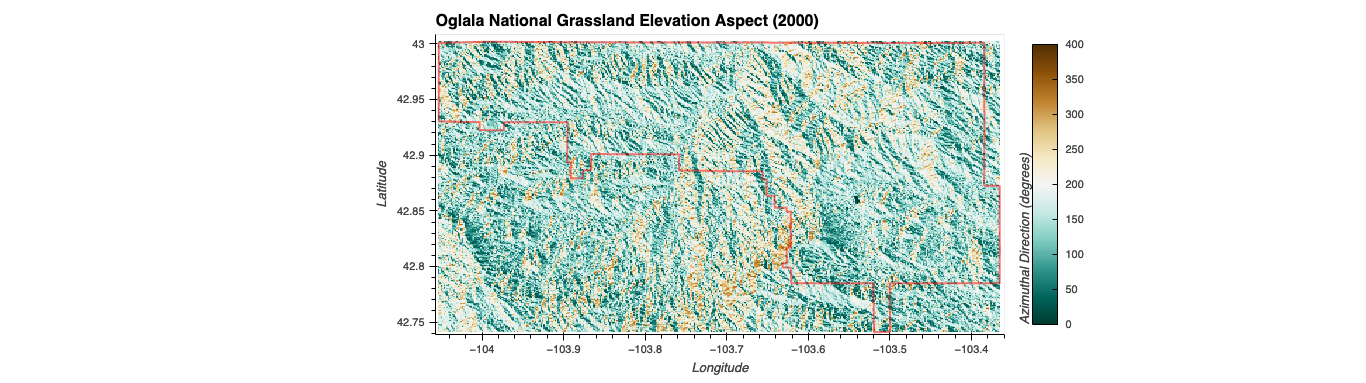

In [15]:
# plot = (grasslands[0]['elevation_plot'] *
#     grasslands[0]['original_gdf']
#     .to_crs(grasslands[0]['utm_epsg'])
#     .hvplot(crs=grasslands[0]['utm_epsg'],
#     line_color='red', color='None',
#     alpha=0.5,
#     line_width=2)).opts(
#         title=f"{grasslands[0]['name']} Elevation Aspect (2000)")
# hv.save(plot, f"img/{grasslands[0]['name']} - Elevation Aspect.png")
Image('img/Oglala National Grassland - Elevation Aspect.png')

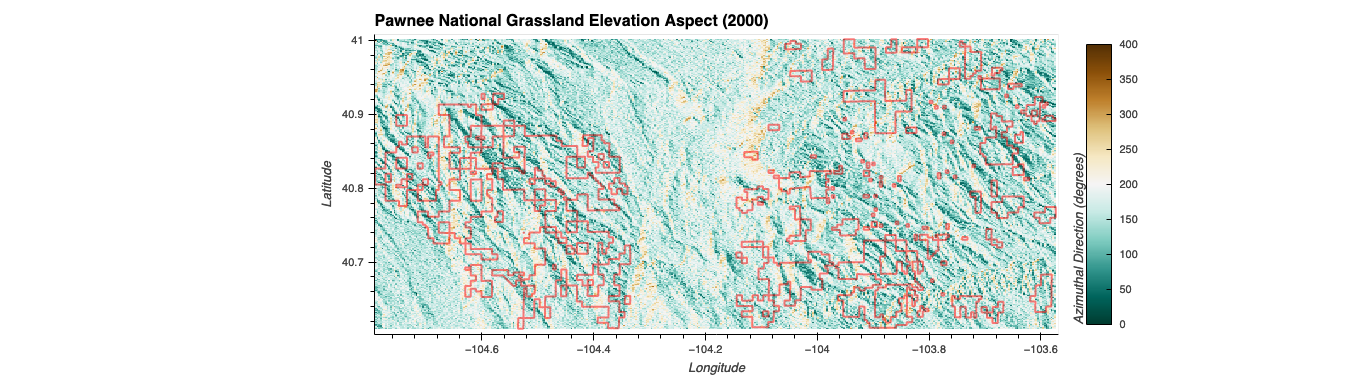

In [16]:
# plot = (grasslands[1]['elevation_plot'] *
#     grasslands[1]['original_gdf']
#     .to_crs(grasslands[1]['utm_epsg'])
#     .hvplot(crs=grasslands[1]['utm_epsg'],
#     line_color='red', color='None',
#     alpha=0.5,
#     line_width=2)).opts(
#         title=f"{grasslands[1]['name']} Elevation Aspect (2000)")
# hv.save(plot, f"img/{grasslands[1]['name']} - Elevation Aspect.png")
Image("img/Pawnee National Grassland - Elevation Aspect.png")

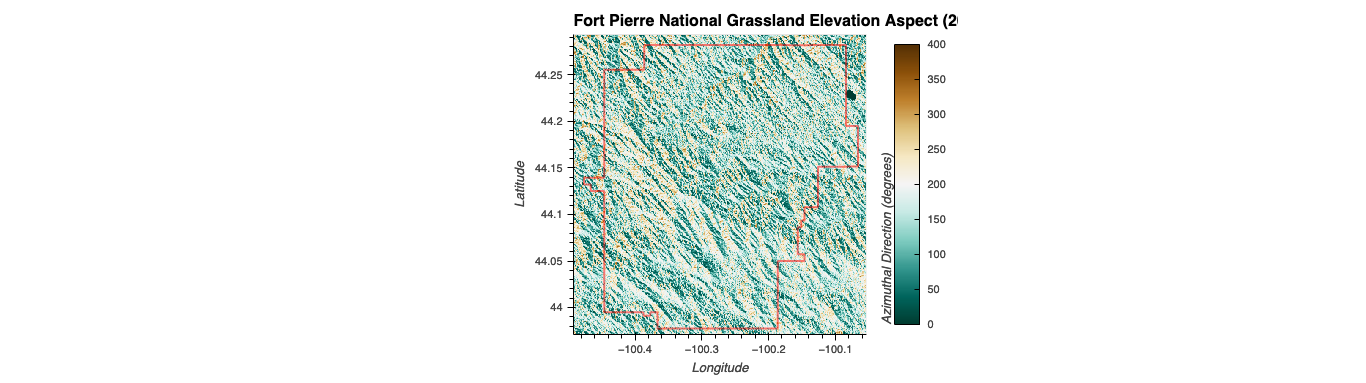

In [17]:
# plot = (grasslands[2]['elevation_plot'] *
#     grasslands[2]['original_gdf']
#     .to_crs(grasslands[2]['utm_epsg'])
#     .hvplot(crs=grasslands[2]['utm_epsg'],
#     line_color='red', color='None', 
#     alpha=0.5,
#     line_width=2)).opts(
#         title=f"{grasslands[2]['name']} Elevation Aspect (2000)")
# hv.save(plot, f"img/{grasslands[2]['name']} - Elevation Aspect.png")
Image("img/Fort Pierre National Grassland - Elevation Aspect.png")

## Data Source # 3 Soil Variable - Polaris pH (2019)

Following the elevation data, I downloaded POLARIS soil property (pH) published by Duke University. Additional details at https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2018WR022797

### Data Citation
Duke University. (2019). *POLARIS Soil Properties v1.0: pH Mean 60-100 cm Depth* [Data set]. Duke University Hydrology Laboratory. Accessed 2023-12-18 from http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/

In [18]:
def get_polaris_urls(gdf):
  """
  Generate a list of POLARIS URLs based on the given GeoDataFrame.

  Parameters:
  gdf (GeoDataFrame): A GeoDataFrame containing spatial data.

  Returns:
  list: A list of POLARIS URLs.

  """
  min_lon, min_lat, max_lon, max_lat = gdf.total_bounds

  def round_min(num):
    return int(math.floor(num))

  def round_max(num):
    return int(math.ceil(num))

  min_lon, min_lat, max_lon, max_lat = \
    round_min(min_lon), \
    round_min(min_lat), \
    round_max(max_lon), \
    round_max(max_lat)

  lon_range = np.arange(min_lon, max_lon + 1, 1)
  lat_range = np.arange(min_lat, max_lat + 1, 1)

  # Generate combinations of longitudes and latitudes
  lon_combinations = list(combinations(lon_range, 2))
  lon_combinations = [(lon1, lon2) for lon1, lon2 in lon_combinations if abs(lon1 - lon2) == 1]
  lat_combinations = list(combinations(lat_range, 2))
  lat_combinations = [(lat1, lat2) for lat1, lat2 in lat_combinations if abs(lat1 - lat2) == 1]

  polaris_urls = []
  for lon1, lon2 in lon_combinations:
    for lat1, lat2 in lat_combinations:
      polaris_url = \
        'http://hydrology.cee.duke.edu' + \
        '/POLARIS/PROPERTIES/v1.0' + \
        '/ph/mean/60_100' + \
        f'/lat{lat1}{lat2}_lon{lon1}{lon2}.tif'
      polaris_urls.append(polaris_url)
  return polaris_urls

In [19]:
for index, grassland in enumerate(grasslands):
    """
    This code block iterates over a list of grasslands and performs the following steps:
    1. Retrieves Polaris URLs for each grassland.
    2. Adds the Polaris URLs to the grassland dictionary.
    3. Downloads and stores the Polaris data arrays for each URL in the polaris_dir.
    4. Merges the Polaris data arrays into a single array.
    5. Adds the merged array to the grassland dictionary.
    """
    polaris_das = []
    polaris_urls = get_polaris_urls(grassland['original_gdf'])
    grasslands[index]['polaris_urls'] = polaris_urls
    for url in polaris_urls:
        filename = os.path.basename(url)
        filepath = os.path.join(polaris_dir, filename)
        if not os.path.exists(filepath):
            resp = requests.get(url)
            with open(filepath, 'wb') as f:
                f.write(resp.content)
        polaris_da = rxr.open_rasterio(filepath, masked=True).squeeze()
        polaris_das.append(polaris_da)
    ph_da = rxrmerge.merge_arrays(polaris_das)
    grasslands[index]['ph_da'] = ph_da
    polaris_das = []

In [20]:
for index, grassland in enumerate(grasslands):
    """
    Process the grasslands data by reprojecting and clipping the 'ph_da' attribute.
    """
    grasslands[index]['ph_da'] = (
        grasslands[index]['ph_da']
        .rio.reproject_match(grasslands[index]['elevation_data'])
        .rio.clip_box(*grasslands[index]['original_gdf'].total_bounds)
    )

In [21]:
for index, grassland in enumerate(grasslands):
    """
    Add a color plot of pH values to each grassland in the list.
    """
    grasslands[index]['ph_plot'] = grasslands[index]['ph_da'].hvplot(
        cmap='terrain',
        x='x', y='y', 
        crs=grasslands[index]['utm_epsg'],
        colorbar=True,
        clabel='pH Scale (0-14)',
        clim=(4, 8)
    )

### Soil pH Maps

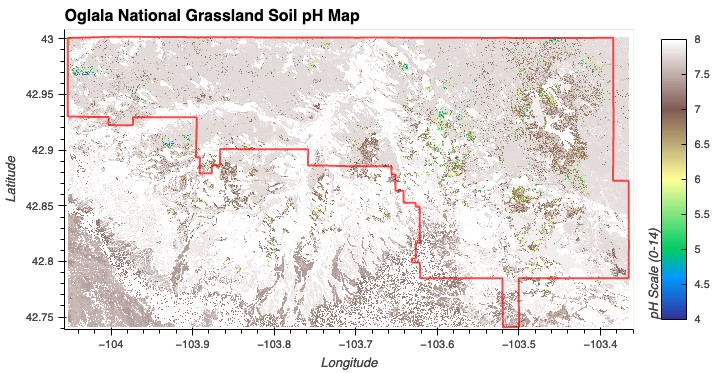

In [22]:
# plot = (grasslands[0]['ph_plot'] * 
#  grasslands[0]['original_gdf'].to_crs(grasslands[0]['utm_epsg'])
#  .hvplot(crs=grasslands[0]['utm_epsg'], 
#         line_color='red', color='None',
#         alpha=0.7, line_width=2)
# ).opts(xlabel='Longitude', ylabel='Latitude',
#        title=f"{grasslands[0]['name']} Soil pH Map")
# hv.save(plot, f"img/{grasslands[0]['name']} - Soil pH Map.png")
Image("img/Oglala National Grassland - Soil pH Map.png")

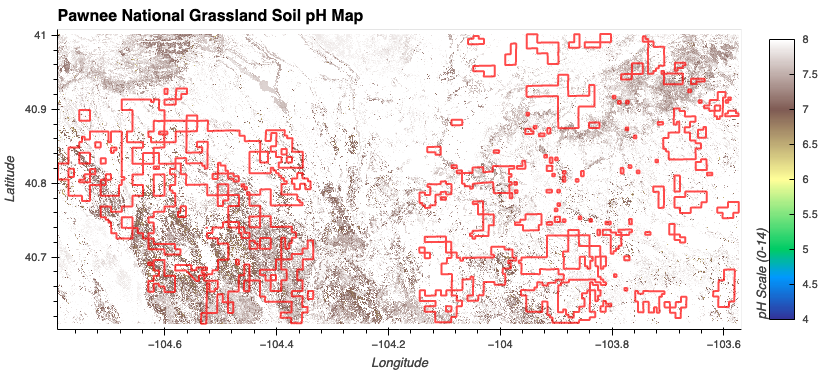

In [23]:
# plot = (grasslands[1]['ph_plot'] * 
#  grasslands[1]['original_gdf'].to_crs(grasslands[1]['utm_epsg'])
#  .hvplot(crs=grasslands[1]['utm_epsg'], 
#         line_color='red', color='None',
#         alpha=0.7, line_width=2)
# ).opts(xlabel='Longitude', ylabel='Latitude',
#        title=f"{grasslands[1]['name']} Soil pH Map")
# hv.save(plot, f"img/{grasslands[1]['name']} - Soil pH Map.png")
Image("img/Pawnee National Grassland - Soil pH Map.png")

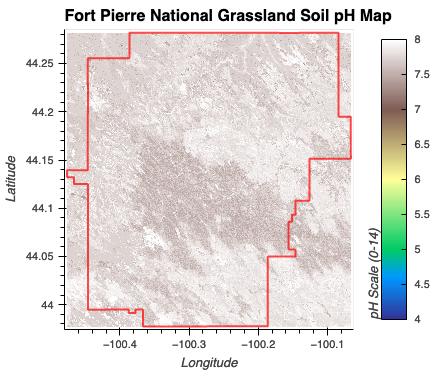

In [24]:
# plot = (grasslands[2]['ph_plot'] * 
#  grasslands[2]['original_gdf'].to_crs(grasslands[2]['utm_epsg'])
#  .hvplot(crs=grasslands[2]['utm_epsg'], 
#         line_color='red', color='None',
#         alpha=0.7, line_width=2)
# ).opts(xlabel='Longitude', ylabel='Latitude',
#        title=f"{grasslands[2]['name']} Soil pH Map")
# hv.save(plot, f"img/{grasslands[2]['name']} - Soil pH Map.png")
Image("img/Fort Pierre National Grassland - Soil pH Map.png")

## Data Source # 4 MACAv2

Last, I downloaded two climate variables (precipitation and specific humidity) from Northwest Knowledge at https://climate.northwestknowledge.net/MACA/data_catalogs.php

### Climate Variable: Precipitation (mm)
Monthly Precipitation Amount - Total monthly precipitation at surface: includes both liquid and solid phases from all types of clouds (both large-scale and convective)
(sum(interval: 24 hours): sum over days)


#### Data Citation
Northwest Knowledge Network. (2023). *MACAv2 Metdata Precipitation Data - CCSM4 Historical 1950-2005* [Data set]. Northwest Knowledge Network. Accessed 2023-12-18 from http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_macav2metdata_pr_CCSM4_r6i1p1_historical_1950_2005_CONUS_monthly.nc?var=precipitation&disableProjSubset=on&horizStride=1&time_start=2005-01-15T00%3A00%3A00Z&time_end=2005-12-15T00%3A00%3A00Z&timeStride=1&addLatLon=true&accept=netcdf

In [25]:
maca_precip_url = (
    "http://thredds.northwestknowledge.net:8080/thredds/ncss"
    "/agg_macav2metdata_pr_CCSM4_r6i1p1_historical_1950_2005_CONUS_monthly.nc"
    "?var=precipitation"
    "&disableProjSubset=on"
    "&horizStride=1"
    "&time_start=2005-01-15T00%3A00%3A00Z"
    "&time_end=2005-12-15T00%3A00%3A00Z"
    "&timeStride=1&addLatLon=true&accept=netcdf"
)

In [26]:
if not os.listdir(precipitation_dir):
    resp = requests.get(maca_precip_url)
    with open(os.path.join(precipitation_dir, 'maca_precip.nc'), 'wb') as f:
        f.write(resp.content)

In [27]:
for index, grassland in enumerate(grasslands):
    """
    Open the precipitation data for each grassland and reproject and clip it.
    """
    precipitation_file = os.path.join(precipitation_dir, 'maca_precip.nc')
    maca_ds = xr.open_dataset(precipitation_file, engine='netcdf4')
    maca_crs = maca_ds.attrs['coordinate_system'].split(':')[1] #epsg:4326
    maca_ds = maca_ds.assign_coords(lon=maca_ds.lon - 360)
    precip_da = maca_ds.precipitation
    precip_da.rio.write_crs(maca_crs, inplace=True)
    precip_da.rio.set_spatial_dims('lon', 'lat', inplace=True)
    precip_da.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
    precip_da = precip_da.rio.reproject_match(grasslands[index]['elevation_data'])
    grasslands[index]['precip_clipped_da'] = precip_da.rio.clip_box(
        *grasslands[index]['original_gdf'].total_bounds
    ).mean('time')
    grasslands[index]['precip_plot'] = (grasslands[index]['precip_clipped_da']
        .hvplot(
            cmap='blues',
            clabel='Precipitation (mm)',
            xlabel='Longitude', ylabel='Latitude',
            colorbar=True, 
            clim=(20, 50)
        ))

In [28]:
# import netCDF4

# dataset = netCDF4.Dataset(precipitation_file)
# dataset.variables

### Precipitation Maps

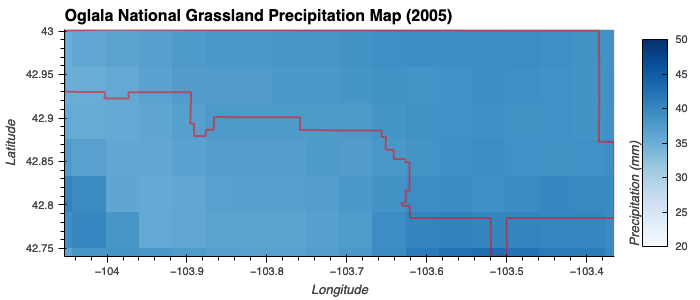

In [29]:
# plot = (
#     grasslands[0]['precip_plot'] *
#     grasslands[0]['original_gdf']
#     .hvplot(alpha=0.5, 
#     color='None', line_width=2, line_color='red')
# ).opts(xlabel='Longitude', ylabel='Latitude',
#        title=f"{grasslands[0]['name']} Precipitation Map (2005)")
# hv.save(plot, f"img/{grasslands[0]['name']} - Precipitation Map.png")
Image("img/Oglala National Grassland - Precipitation Map.png")

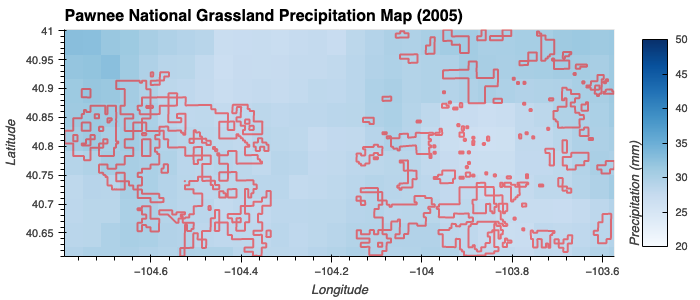

In [30]:
# plot = (
#     grasslands[1]['precip_plot'] *
#     grasslands[1]['original_gdf']
#     .hvplot(alpha=0.5, 
#     color='None', line_width=2, line_color='red')
# ).opts(xlabel='Longitude', ylabel='Latitude',
#        title=f"{grasslands[1]['name']} Precipitation Map (2005)")
# hv.save(plot, f"img/{grasslands[1]['name']} - Precipitation Map.png")
Image("img/Pawnee National Grassland - Precipitation Map.png")

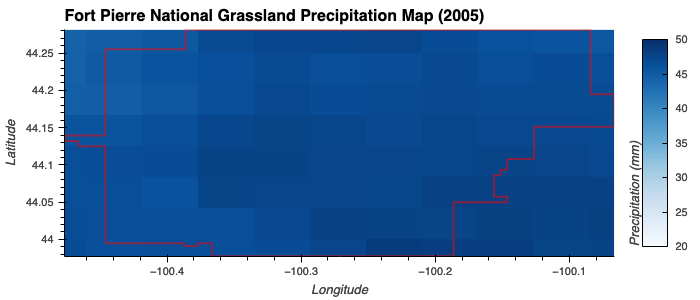

In [31]:
# plot = (
#     grasslands[2]['precip_plot'] *
#     grasslands[2]['original_gdf']
#     .hvplot(alpha=0.5, 
#     color='None', line_width=2, line_color='red')
# ).opts(xlabel='Longitude', ylabel='Latitude',
#        title=f"{grasslands[2]['name']} Precipitation Map (2005)")
# hv.save(plot, f"img/{grasslands[2]['name']} - Precipitation Map.png")
Image("img/Fort Pierre National Grassland - Precipitation Map.png")

### Climate Variable: Specific Humidity

Monthly Average of Daily Mean Near-Surface Specific Humidity (time: mean(interval: 24 hours); mean over days)

#### Data Citation
Northwest Knowledge Network. (2023). *MACAv2 Metdata Specific Humidity Data - CCSM4 Historical 1950-2005* [Data set]. Northwest Knowledge Network. Accessed 2023-12-18 from http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_macav2metdata_huss_CCSM4_r6i1p1_historical_1950_2005_CONUS_monthly.nc?var=specific_humidity&disableLLSubset=on&disableProjSubset=on&horizStride=1&time_start=2005-01-15T00%3A00%3A00Z&time_end=2005-12-15T00%3A00%3A00Z&timeStride=1&accept=netcdf

In [32]:
maca_humidity_url = (
    "http://thredds.northwestknowledge.net:8080/thredds/ncss"
    "/agg_macav2metdata_huss_CCSM4_r6i1p1_historical_1950_2005_CONUS_monthly.nc"
    "?var=specific_humidity"
    "&disableLLSubset=on"
    "&disableProjSubset=on"
    "&horizStride=1"
    "&time_start=2005-01-15T00%3A00%3A00Z"
    "&time_end=2005-12-15T00%3A00%3A00Z"
    "&timeStride=1&accept=netcdf"
)

In [33]:
if not os.listdir(humidity_dir):
    resp = requests.get(maca_humidity_url)
    with open(os.path.join(humidity_dir, 'maca_humidity.nc'), 'wb') as f:
        f.write(resp.content)

In [34]:
for index, grassland in enumerate(grasslands):
    """
    Open the humidity data for each grassland and reproject and clip it.
    """
    humidity_file = os.path.join(humidity_dir, 'maca_humidity.nc')
    humidity_ds = xr.open_dataset(humidity_file, engine='netcdf4')
    humidity_crs = humidity_ds.attrs['coordinate_system'].split(':')[1]
    humidity_ds = humidity_ds.assign_coords(lon=humidity_ds.lon - 360)
    humidity_da = humidity_ds.specific_humidity
    humidity_da.rio.write_crs(humidity_crs, inplace=True)
    humidity_da.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
    humidity_da = humidity_da.rio.reproject_match(grasslands[index]['elevation_data'])
    grasslands[index]['humidity_clipped_da'] = humidity_da.rio.clip_box(
        *grasslands[index]['original_gdf'].total_bounds
    ).mean('time')
    grasslands[index]['humidity_plot'] = (grasslands[index]['humidity_clipped_da']
        .hvplot(
            cmap='blues',
            colorbar=True,
            clabel='Specific Humidity (kg/kg)',
            clim=(0.0045, 0.0060)
        ))

In [35]:
# import netCDF4

# dataset = netCDF4.Dataset(humidity_file)
# dataset.variables

### Humidity Maps

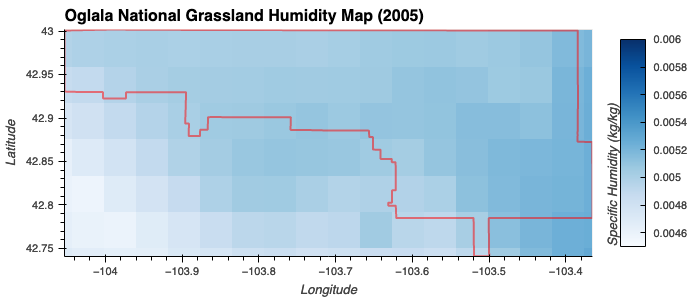

In [36]:
# plot = (
#     grasslands[0]['humidity_plot'] *
#     grasslands[0]['original_gdf']
#     .hvplot(alpha=0.5,
#         color='None', line_width=2, line_color='red')
# ).opts(xlabel='Longitude', ylabel='Latitude',
#        title=f"{grasslands[0]['name']} Humidity Map (2005)")
# hv.save(plot, f"img/{grasslands[0]['name']} - Humidity Map.png")
Image("img/Oglala National Grassland - Humidity Map.png")

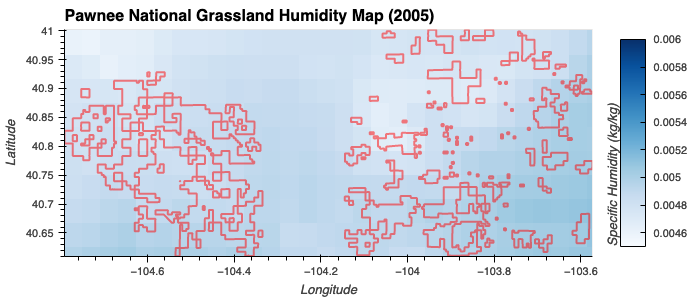

In [37]:
# plot = (
#     grasslands[1]['humidity_plot'] *
#     grasslands[1]['original_gdf']
#     .hvplot(alpha=0.5,
#     color='None', line_width=2, line_color='red')
# ).opts(xlabel='Longitude', ylabel='Latitude',
#        title=f"{grasslands[1]['name']} Humidity Map (2005)")
# hv.save(plot, f"img/{grasslands[1]['name']} - Humidity Map.png")
Image("img/Pawnee National Grassland - Humidity Map.png")

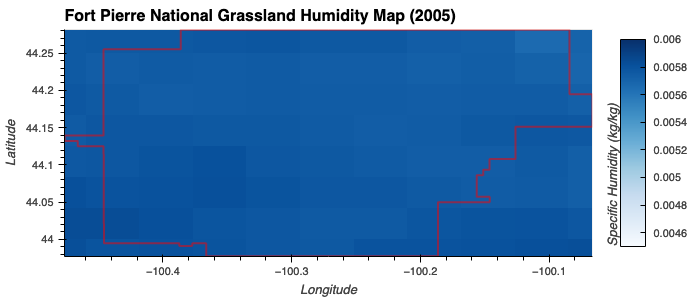

In [38]:
# plot = (
#     grasslands[2]['humidity_plot'] *
#     grasslands[2]['original_gdf']
#     .hvplot(alpha=0.5,
#     color='None', line_width=2, line_color='red')
# ).opts(xlabel='Longitude', ylabel='Latitude',
#        title=f"{grasslands[2]['name']} Humidity Map (2005)")
# hv.save(plot, f"img/{grasslands[2]['name']} - Humidity Map.png")
Image("img/Fort Pierre National Grassland - Humidity Map.png")

# Fuzzy Logic Model

Based on the quick background search, the following are defined as the preferred conditions for Sorghastrum Nutans:
* **Elevation (Low or Moderate):** A trapezoidal membership function that covers elevations from 0 to 2000 meters
* **Slightly Acidic/Neutral Soil:** Gaussian membership function centered at a pH of 6.5 with a spread of 1.
* **Moderate or High Precipitatoin:** Gaussian membership function centered at 35 mm with a spread of 10 mm.
* **Moderate Humidity:** Gaussian membership function centered at 0.00500 kg/kg with a spread of 0.001.

Additionally, well-drained soil is inferred indirectly from having moderate to high precipitation but while the specific humidity isn't high. 

These parameters haven't gone through any rigirous selection process. These data sources are also not comprehensive enough to build a solid model. \
The following is purely demonstrating the ability manipulate and harmonize DataArray objects.

In [39]:
# Define the fuzzy membership functions
x_elevation = np.arange(0, 2000, 1)
x_ph = np.arange(0, 14, 0.1)
x_precipitation = np.arange(0, 60, 1)
x_humidity = np.arange(0.004, 0.007, 0.0001)
low_or_moderate_elevation = fuzz.trapmf(x_elevation, [0, 0, 2000, 2000])
moderate_ph = fuzz.gaussmf(x_ph, 6.5, 1)
moderate_or_high_precipitation = fuzz.gaussmf(x_precipitation, 45, 15)
moderate_humidity = fuzz.gaussmf(x_humidity, 0.00500, 0.001)

In [40]:
for index, grassland in enumerate(grasslands):
    """
    Calculate the fuzzy membership values for each grassland.
    """
    elevation_data = grasslands[index]['elevation_data']
    elevation_aspect = grasslands[index]['elevation_aspect']
    ph_data = grasslands[index]['ph_da']
    precip_data = grasslands[index]['precip_clipped_da']
    humidity_data = grasslands[index]['humidity_clipped_da']

    low_or_moderate_elevation_memership = \
        fuzz.interp_membership(x_elevation, low_or_moderate_elevation, elevation_data)

    grasslands[index]['fuzz_low_or_moderate_elevation'] = \
        xr.DataArray(
            np.array(low_or_moderate_elevation_memership),
            dims=['y', 'x'],
            coords={'y': elevation_data.y, 'x': elevation_data.x}
        )
    
    moderate_ph_memership = \
        fuzz.interp_membership(x_ph, moderate_ph, ph_data)
    
    grasslands[index]['fuzz_moderate_ph'] = \
        xr.DataArray(
            np.array(moderate_ph_memership),
            dims=['y', 'x'],
            coords={'y': ph_data.y, 'x': ph_data.x}
        )
    
    mod_or_high_precipitation_memership = \
        fuzz.interp_membership(x_precipitation, moderate_or_high_precipitation, precip_data)

    grasslands[index]['fuzz_modhigh_precipitation'] = \
        xr.DataArray(
            np.array(mod_or_high_precipitation_memership),
            dims=['y', 'x'],
            coords={'y': precip_data.y, 'x': precip_data.x}
        )
    
    moderate_humidity_memership = \
        fuzz.interp_membership(x_humidity, moderate_humidity, humidity_data)
    
    grasslands[index]['fuzz_moderate_humidity'] = \
        xr.DataArray(
            np.array(moderate_humidity_memership),
            dims=['y', 'x'],
            coords={'y': humidity_data.y, 'x': humidity_data.x}
        )
    
    grasslands[index]['well_drained_soil'] = (
        np.fmin(
            grasslands[index]['fuzz_modhigh_precipitation'],
            grasslands[index]['fuzz_moderate_humidity']
        )
    )

    grasslands[index]['fuzz_situability'] = \
        grasslands[index]['well_drained_soil'] \
        * grasslands[index]['fuzz_low_or_moderate_elevation'] \
        * grasslands[index]['fuzz_moderate_ph']

## Situability Maps

Based on the fuzzy memberships functions defined, Oglala National Grassland shows having the most situatble areas of the three study sites.

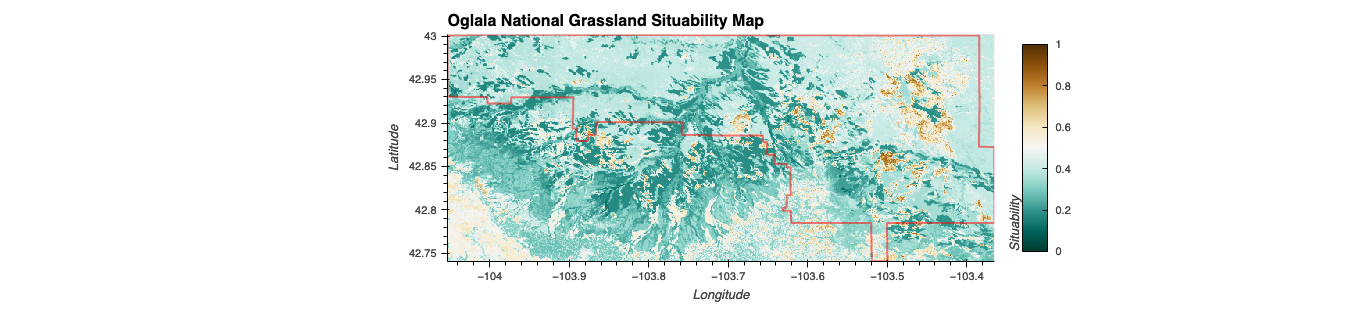

In [41]:
# plot = (
#     grasslands[0]['fuzz_situability'].hvplot.image(
#     rasterize=True, cmap='BrBG_r',
#     colorbar=True,
#     clim=(0, 1),
#     clabel='Situability',
#     x='x', y='y'
# ) *
#     grasslands[0]['original_gdf']
#     .hvplot(alpha=0.5,
#         color='None', line_width=2, line_color='red')
# ).opts(xlabel='Longitude', ylabel='Latitude',
#        title=f"{grasslands[0]['name']} Situability Map")
# hv.save(plot, f"img/{grasslands[0]['name']} - Situability Map.png")
Image("img/Oglala National Grassland - Situability Map.png")

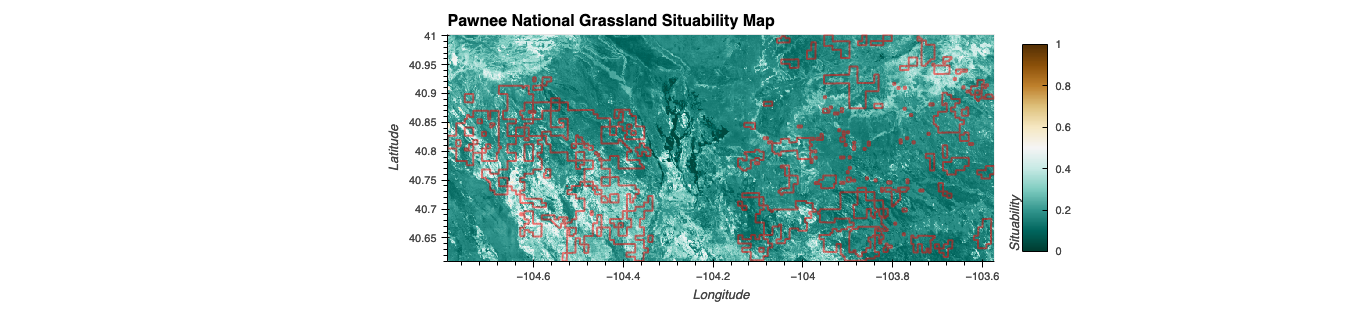

In [42]:
# plot = (
#     grasslands[1]['fuzz_situability'].hvplot.image(
#     rasterize=True, cmap='BrBG_r',
#     colorbar=True,
#     clim=(0, 1),
#     clabel='Situability',
#     x='x', y='y'
# ) *
#     grasslands[1]['original_gdf']
#     .hvplot(alpha=0.5,
#         color='None', line_width=2, line_color='red')
# ).opts(xlabel='Longitude', ylabel='Latitude',
#        title=f"{grasslands[1]['name']} Situability Map")
# hv.save(plot, f"img/{grasslands[1]['name']} - Situability Map.png")
Image("img/Pawnee National Grassland - Situability Map.png")

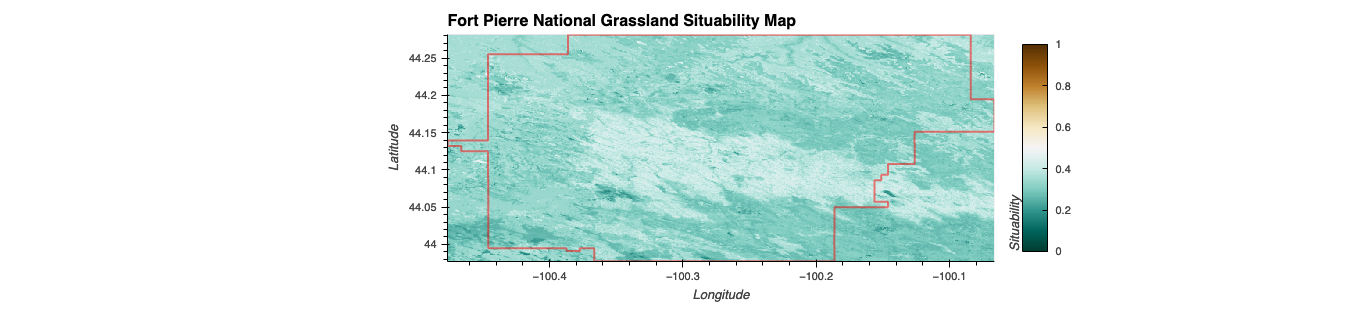

In [43]:
# plot = (
#     grasslands[2]['fuzz_situability'].hvplot.image(
#     rasterize=True, cmap='BrBG_r',
#     colorbar=True,
#     clim=(0, 1),
#     clabel='Situability',
#     x='x', y='y'
# ) *
#     grasslands[2]['original_gdf']
#     .hvplot(alpha=0.5,
#         color='None', line_width=2, line_color='red')
# ).opts(xlabel='Longitude', ylabel='Latitude',
#        title=f"{grasslands[2]['name']} Situability Map")
# hv.save(plot, f"img/{grasslands[2]['name']} - Situability Map.png")
Image("img/Fort Pierre National Grassland - Situability Map.png")

In [44]:
%%capture
%%bash
jupyter nbconvert sorghastrum-nutans.ipynb --to html --no-input